## ![CESI](./photo_livrable/Logo_cesi.png)

# Projet Leyenda
## Livrable 1 - Classification binaire
|Auteurs|
|---|
|Karim Salhi
|Corentin Devrouete
|Hugo Larose
|Pierre-Alain Tietz

### Importation des librairies

Dans un premier temps nous allons importer toutes les libraires nécessaire à notre classification :
- **Keras**, la bibliothèque Keras permet d'interagir avec les algorithmes de réseaux de neurones profonds et d'apprentissage automatique, notamment Tensorflow.
- **Tensorflow**, TensorFlow est un outil open source d'apprentissage automatique développé par Google.
- **Numpy**, NumPy est une bibliothèque pour langage de programmation Python, destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
- **Matplotlib**, est une bibliothèque utilisée pour tracer et visualiser des données à l'aide de graphiques.
- **Scikit-Learn**, est une bibliothèque utilisée pour l'apprentissage automatique et l'analyse de métriques

In [3]:
import keras
import numpy
import sklearn
import tensorflow
import matplotlib
import pydot
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as kb
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from sklearn.metrics import roc_curve,RocCurveDisplay,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(tf.__version__)

2.7.0


### Initialisation des hyperparamètres


Ces paramètres nous servirons tout au long de notre programme d'intelligence artificielle :

BATCH_SIZE : Cette variable est la taille du lot qui définit le nombre d'échantillons qui seront propagés à travers le réseau.

VALIDATION_SPLIT : C'est un moyen de prédire l'ajustement d'un modèle à un ensemble de tests hypothétique lorsqu'un ensemble de tests explicite n'est pas disponible

EPOCHS : Une époque fait référence à un cycle à travers l'ensemble de données d'entraînement complet.

STEPS_PER_EPOCH : C'est le nombre d'itérations de lots avant qu'une epoch soit considérée comme terminée. Avec un ensemble d'entraînement de taille fixe, on peut l'ignorer, mais cela peut être utile si nous avions un énorme ensemble de données ou des augmentations de données aléatoires , c'est-à-dire si l'ensemble d'entraînement a une taille infinie.

Ensuite nous definissons le chemin des répertoires vers le jeu de données et nos sauvegarde des modèles.

In [8]:
BATCH_SIZE = 16
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
VALIDATION_SPLIT = 0.2
EPOCHS = 50
STEPS_PER_EPOCH = 1000

In [9]:
PATH_DATASET = os.path.join('./CNN/dataset/train_val/')
PATH_DATASET_TEST = os.path.join('D:\\CESI\\A5\\Data\\Datasets\\Test')
PATH_SAVE_MODEL = os.path.join('C:\\Users\\karim\\Documents\\GitHub\\Leyenda\\Livrable1\\model\\cnn_real.h5')

### Création des jeux de données 

Avant de créer notre jeu de données nous avons supprimer certaine image du jeu de données pour avoir autant de photos que de non photo. Grâce à un programme python qui supprime de façon équilibré les textes, schéma, peintures, dessins. Notre jeu de données contient donc autant de photos que de non photos. 

``image_dataset_from_directory()``  Permet de créer un dataset à partir d'un répertoire (dans notre cas, le dossier contenant nos images). Nous en profitons pour récupérer les variables de classes, qui correspondent aux noms de nos sous-répetoires, ici `photo` et `autre`

``image_size`` Correspond à la taille des images souhaitées

``seed`` Cette constante permet de reproduire le même aléatoire à chaque redémarrage du programme.

``subset`` Permet de définir si le dataset et celui d'entraînement ou de validation

In [10]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
)

CLASSES = dataset_train.class_names
NB_CLASSES = len(dataset_train.class_names)
print(f'Le dataset comporte {NB_CLASSES} classes : {CLASSES}')

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Le dataset comporte 2 classes : ['Autre', 'Photo']


### Mise en cache

Nous allons mettre en mémoire les images pour lancer les époques cela permettera de les effectuer plus rapidement. Cela ce fait grâce aux fonction ``cache().prefecth()``

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

### Augmentation du jeu de donnée-C

Pour entrainer un réseau de neurones performant, le rôle des données est plus que primordiale car le nombre de données influent énormément dans le score du modèle. Pour augmenter notre nombre de données qui est assez faible (20000 images), nous utilisons un technique qui s'appelle la data augmentation. 

Le but étant de prendre nos images existantes et de les modifier légerement afin de conserver la cohérence d'une image tout en gagnant de nouvelles images. 

 ![data augmentation](./photo_livrable/data_augmentation.png)


Ici, dans notre cas, nous ajoutons des rotations d'image (RandomRotation), des retournements d'image aléatoire (RandomFlip) et pour finir des 


In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2, fill_mode='reflect',
                          interpolation='bilinear', fill_value=0.0),
    layers.RandomZoom(0.2),
])

### Définition du modèle

>**Input** -> Pour notre modèle nous avons décidé de commencer par une couche de redimensionnement des images du dataset, donc on normalise toutes les images en les divisant par 255. 
>
>**Couches convolutives** -> Ensuite nous faisons 3 couches convolutives sur lesquelles nous doublons le nombre de neuronnes sur chacunes comparé à celle d'avant tout en appliquant un maxpooling pour sous-échantillonner leurs représentation d'entrée en réduisant leurs dimensionnalité.
>
>**Fonction d'activation** -> De plus sur ces couches nous utilisons la fonction d'activation relu car elle permet tout simplement de remplacer les résultats négatifs par zéro.
>
>**Dropout** -> Suite à celle-ci nous réalisons une dropout de 20% sur le modèle pour le rendre encore plus aléatoire.
>
>**Moyenne des couches et applatissement** -> Pour remmettre le modèle droit nous faison une couche de globalaveragepooling qui regroupe les données en faisant la moyenne avec une flatten qui met tout à 1 dimension.
>
>**Couches dense** -> Enfin nous réalisons une première couche dense avec la même fonction d'activation que les couches de convolutions, qui est une couche de sortie a 128 neuronnes sur laquelle nous faisons une dernière couche dense qui est notre sortie à 1 neuronne utilisant une fonction d'activation sigmoide car nous n'avons qu'1 prédiction à faire, sin ous en avions plusieurs nous aurions utilisé alors la softmax.

In [13]:
model = tf.keras.Sequential([
    data_augmentation,

    layers.Rescaling(
        1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


## Métriques de performance

>**Optimizer** -> Nous utilisons l'optimizer adam car c'est un gradient stochastique et nous évite d'avoir des minimum local.
>
>**Loss** -> Ensuite nous utilisons une fonction de perte en binary crossentropy car elle est la plus adapté a notre modèle étant donné qu'on ne doit comparer que 2 valeurs, soit une photo ou non.
>
>**Metriques** -> Enfin nous définissons nos métrics, l’accuracy qui permet de connaître la proportion de bonnes prédictions par rapport à toutes les prédictions, la precision est le rapport entre les vrais positifs et le nombre total de positifs prédits, le recall nous donne le nombre de positifs réel (total true positive) et enfin le f1_score combine subtilement la précision et le rappel, le nombre de vrais négatifs (tn) n’est pas pris en compte.

In [5]:
# precision =  true positives / (true positives + false positives)
def precision(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + kb.epsilon())
    return recall

# f1 score
def f1_score(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + kb.epsilon())
    f1_score = 2*(precision*recall)/(precision+recall+kb.epsilon())
    return f1_score


model.compile(
   optimizer = 'adam',
   loss = tf.losses.BinaryCrossentropy(),
   metrics = ['accuracy', f1_score, precision, recall])

### Schéma du modèle

Voici un schéma du modèle défini précédemment.

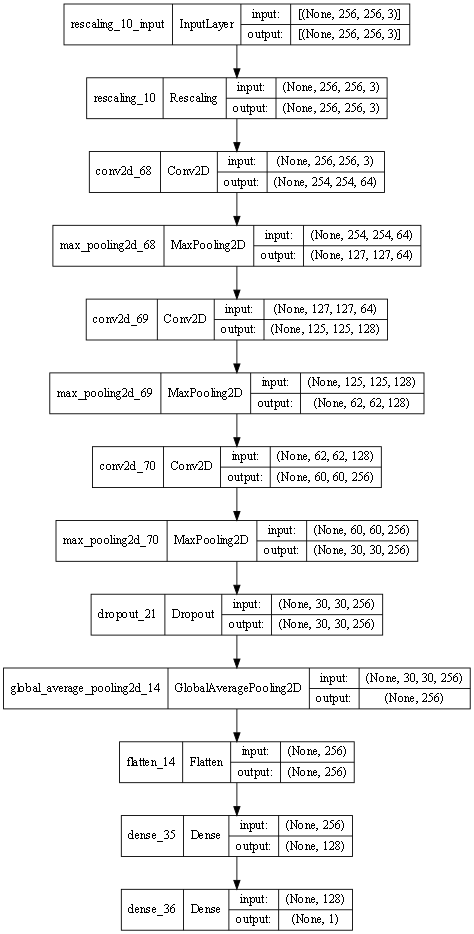

In [19]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Dessiner les courbes

On dessine les courbes pour avoir un visuel sur la précision de nos modèles. Grâce à ceux-ci, on peut voir facilement l'évolution de l'efficacité de notre modèle et si il y a du surapprentissage.

On les dessine en comparant la précision et la perte du modèle d'entraînement avec ceux du modèle de validation.

In [15]:
def statistics(model_save) :
    acc = model_save.history['accuracy']
    val_acc = model_save.history['val_accuracy']

    loss = model_save.history['loss']
    val_loss = model_save.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.ylim([0, 1])
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.ylim([0, 1])
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Entraînement

> Si un modèle existe déjà alors nous le reprennons pour ne pas a voir a le réentrainer, sinon nous entrainons le modèle par un "model.fit" tout en utilisant les hyper paramètres définit tout au début sur notre dataset de train. Puis nous enregistrons le modèle.

(le tf.device nous permet de dire à notre pc d'utiliser le GPU qui est plus rapide que le CPU)

In [16]:
def get_model(newModel=True):
    if newModel == True:
        with tf.device('/device:GPU:0'):
            model_history = model.fit(dataset_train.repeat(), validation_data = dataset_test, epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH)
        statistics(model_history)
        keras.models.save_model(model, PATH_SAVE_MODEL)
        return model
    else :
        return keras.models.load_model(PATH_SAVE_MODEL, custom_objects={'f1_score':f1_score, 'precision':precision, 'recall':recall})   

model = get_model(newModel=False)


### Interprétation des métriques

On peut voir que la précision de nos courbes est bonne, atteignant les 93% pour la courbe de test après seulement 24 epochs.

![courbe_precision.png](attachment:courbe_precision.png "Courbe précision")
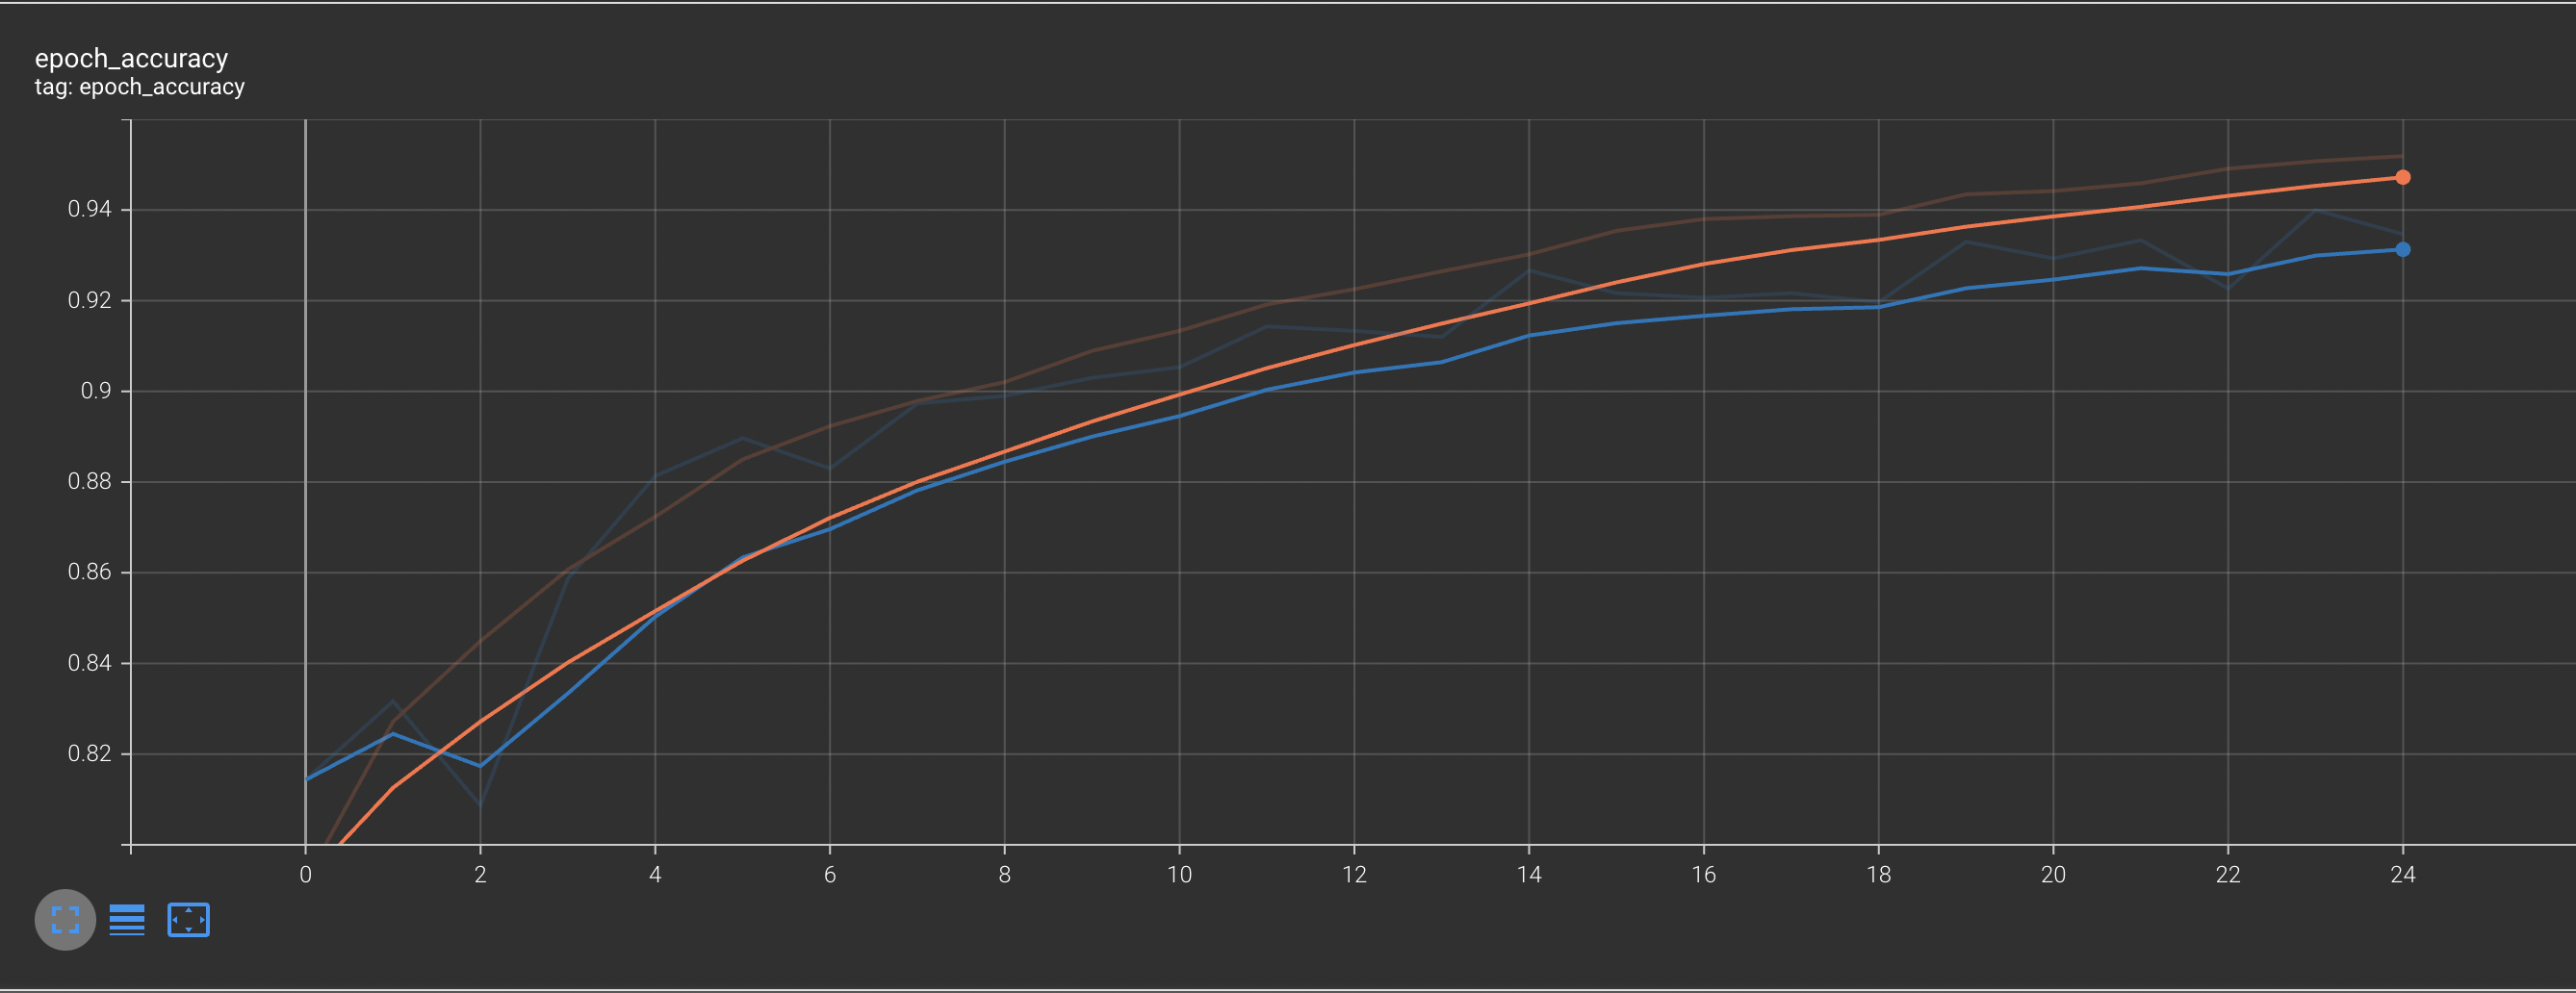

![Statistiques de l'entraînement](./img/model_statistics.png "Statistiques de l'entraînement")

250/250 [==============================] - 136s 540ms/step - loss: 0.2123 - accuracy: 0.9140 - f1_score: 0.9148 - precision: 0.8811 - recall: 0.9621
Test loss: 0.21226361393928528
Test accuracy: 0.9139999747276306
Test F1 Score : 0.9148119688034058
Test Precision : 0.8810715675354004
Test Recall : 0.9621129035949707


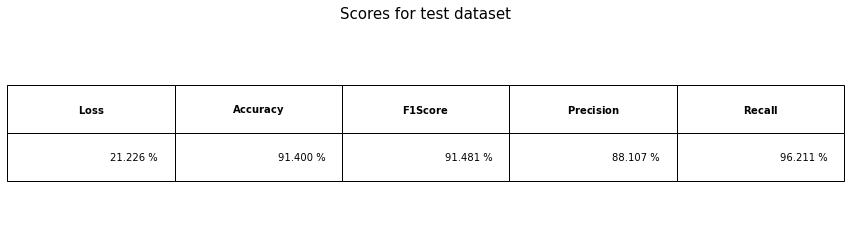

In [17]:
model_evaluation = model.evaluate(dataset_test)


print('Test loss:', model_evaluation[0])
print('Test accuracy:', model_evaluation[1])
print('Test F1 Score :', model_evaluation[2])
print('Test Precision :', model_evaluation[3])
print('Test Recall :', model_evaluation[4])

fig, ax = plt.subplots(1, 1)
column_labels = ["$\\bf{Loss}$",
                 "$\\bf{Accuracy}$",
                 "$\\bf{F1Score}$",
                 "$\\bf{Precision}$",
                 "$\\bf{Recall}$"]
ax.axis('tight')
ax.axis('off')
plt.title('Scores for test dataset', fontsize=15)
table = ax.table(cellText=[['%.3f %%' % (
    i*100) for i in model_evaluation]], colLabels=column_labels, loc="center")
table.scale(2.5, 4)
plt.show()


### Matrice de confusion et ROC -C

Interprétation des résultats

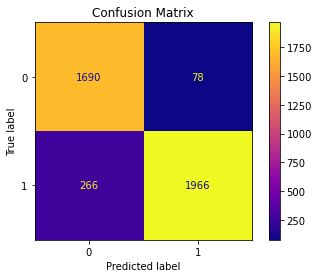

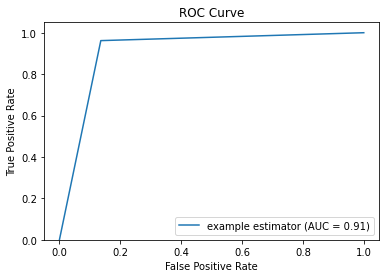

In [19]:
def transformPrediction(n):
    return 0 if n < 0.5 else 1

preds = model.predict(dataset_test)
predicted_categories = list(map(transformPrediction, preds))
true_categories = tf.concat([y for x, y in dataset_test], axis=0)
con_mat = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap="plasma")
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(true_categories, predicted_categories)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.title('ROC Curve')
plt.ylim(0,)
plt.show()

### Test du modèle-C

Interprétation des résultats et comment on les test

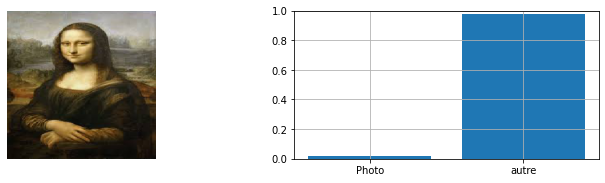

Cette image est 2.15 % une photo et 97.85 % autre.


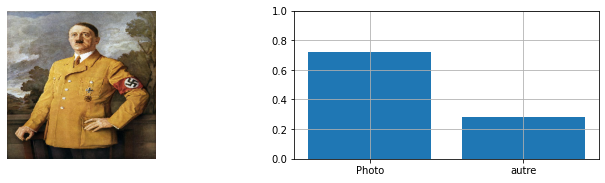

Cette image est 71.98 % une photo et 28.02 % autre.


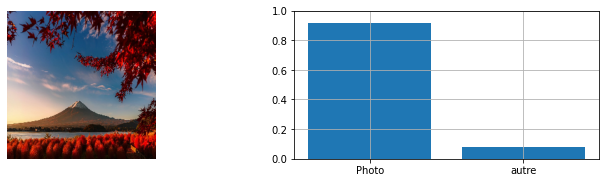

Cette image est 91.75 % une photo et 8.25 % autre.


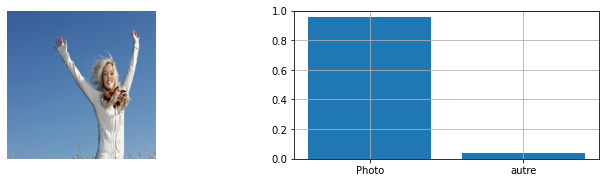

Cette image est 95.84 % une photo et 4.16 % autre.


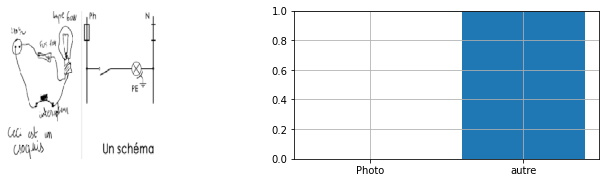

Cette image est 0.00 % une photo et 100.00 % autre.


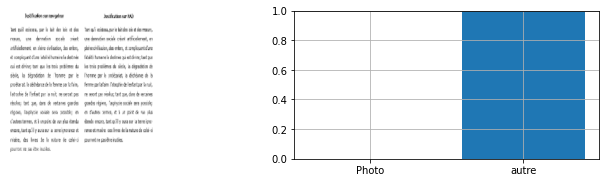

Cette image est 0.00 % une photo et 100.00 % autre.


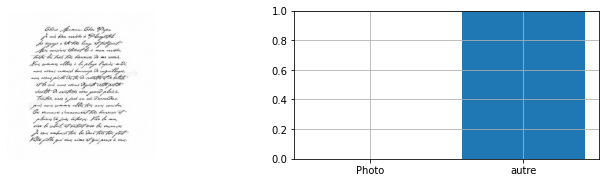

Cette image est 0.00 % une photo et 100.00 % autre.


In [20]:
for pictures in os.listdir(PATH_DATASET_TEST):
    img = image.load_img((PATH_DATASET_TEST + "/" + pictures), target_size = (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.binary)
    
    img  = image.img_to_array(img)
    img  = img.reshape((1,) + img.shape)
    
    prediction = model.predict(img)

    score = prediction[0][0]
    other_score = (1 - score)

    formatted_photo_score = 100 * score
    formatted_other_score = 100 * other_score

    score_array = [score,other_score]

    plt.subplot(2,2,2)
    plt.grid(True)
    plt.bar(["Photo","autre"], score_array)
    #plt.xticks(range(NB_CLASSES), ["Photo","other"], rotation = 45)
    plt.ylim([0, 1])
    plt.show()
    
    print("Cette image est %.2f %% une photo et %.2f %% autre." % (score*100, other_score*100))
    

### Pistes d'amélioration-C

Early stopping ? Epochs ? Hyperparamètres, tout ce qu'on peux améliorer

In [7]:
keras.utils.plot_model(model_cool, show_shapes=True, dpi=64)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
